A notebook for importing induction gamma data from csv files, resampling them to a regular interval, writing the interpolated data into a las file and adding the metadata to the las file header.

Neil Symington
neil.symington@ga.gov.au

In [1]:
import os
import pandas as pd
import sys
# This is for connecting to oracle 
sys.path.append(r'H:\scripts')
import connect_to_oracle # # module imported from H:, contains username and password
import numpy as np
# Key package for processing las files 
import lasio
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import math
from scipy import interpolate

In [2]:
# INterpolation functions
def get_regular_sampling_intervals(min_depth, max_depth, interval_spacing):
    
    newmin= math.ceil(min_depth * (1 /interval_spacing))/(1 /interval_spacing)
    newmax= math.floor(max_depth * (1 /interval_spacing))/(1 /interval_spacing)

    return np.arange(newmin, newmax + interval_spacing, interval_spacing)

def interpolate_logs(depths, data, new_depths):

    interp = interpolate.interp1d(depths, data, kind = 'cubic',
                              bounds_error = False, fill_value = np.nan)
    return interp(new_depths)

In [3]:
# Open the header for the induction and gamma
# This is needed for extracting metadata from teh Geoscience Australia oracle database

df_indgam = pd.read_csv(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\gamma_induction\induction_gamma_header.csv")

enos  = np.unique(df_indgam.ENO.values)

In [4]:
# Now we want to add the spatial coordinates from oracle
# Connect to the database

ora_con = connect_to_oracle.connect_to_oracle()

# Create the sql query

st_eno = ','.join(str(x) for x in enos)

# Now bring in the borehole information from the database

header_query = """

select
   b.borehole_name,
   b.borehole_id,
   drp.DEPTH_REFERENCE_TYPE_ID,
   drp.DEPTH_REFERENCE_ID
   


from

   borehole.boreholes b
   left join borehole.depth_reference_points drp on b.borehole_id = drp.borehole_id
   
   
where
    b.borehole_id in ({})
    

""".format(st_eno)

print(header_query)

ORAPROD connection established for user: U77932


select
   b.borehole_name,
   b.borehole_id,
   drp.DEPTH_REFERENCE_TYPE_ID,
   drp.DEPTH_REFERENCE_ID
   


from

   borehole.boreholes b
   left join borehole.depth_reference_points drp on b.borehole_id = drp.borehole_id
   
   
where
    b.borehole_id in (621622,621623,621624,621625,626981,626984,626986,626987,626988,626989,626990,626991,626992,627061,627062,627063,627064,628981,635728,635729,635730,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635744,635745,635746,635747,635748,635750,635921,635922,635923,635957,635958,635959,635960,636181,636182,636183,636184,636185,636186,636187,636188,636189,636190,636191,636192,636193,636194,636195,636196,636197,636198,636200,636201,636203,636204,636205)
    




In [5]:
# Extract borehole information into a pandas dataframe
df_header = pd.read_sql(header_query, ora_con)

df_header.columns

Index(['BOREHOLE_NAME', 'BOREHOLE_ID', 'DEPTH_REFERENCE_TYPE_ID',
       'DEPTH_REFERENCE_ID'],
      dtype='object')

In [6]:
# Now we want to drop rows if they are not related to the actual reference height datum

for bore in enos:
    # get the depth reference from induction and gamma
    
    mask = df_indgam.ENO == bore
    
    dri = df_indgam[mask]['DEPTH_REFERENCE_TYPE_ID'].values[0]


    # Now drop column if the eno and dri are not matching
    df_header = df_header.drop(df_header[(df_header.BOREHOLE_ID == bore) & (df_header.DEPTH_REFERENCE_TYPE_ID != dri)].index)

In [7]:
outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\gamma_induction"

df_header.to_csv(os.path.join(outdir, "induction_gamma_drp_id.csv"))

In [8]:
# GEt the induciton and gamma data into dataframes
indfile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\gamma_induction\induction_output\csv_files\EK_induction_filtered.csv"

gamfile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\gamma_induction\gamma_output\csv_files\EK_gamma_filtered.csv"

df_induction_data = pd.read_csv(indfile).drop(columns
                                              = 'index').rename(columns = {'focus_log_conductivitity':
                                                                 'INDUCTION_BOREHOLE_COMPENSATED'})

df_gamma_data = pd.read_csv(gamfile).drop(columns = 'index')


In [9]:
df_indgam

,BOREHOLE_NAME,ENO,DEPTH_REFERENCE_ID,ELEVATION_VALUE,INPUT_UNCERTAINTY_Z,ELEVATION_UOM,ELEVATION_DATUM,ELEVATION_DATUM_CONFIDENCE,DEPTH_REFERENCE_TYPE,DEPTH_REFERENCE_DATUM,...,INPUT_UNCERTAINTY_Y,ORIG_INPUT_LOCATION_DATUM,DEPTH_REFERENCE_TYPE_ID,geometry,Reference_datum_height_(mAGL),ground_elevation_(mAHD),lidelev1m,elevation_source,Induction_acquired,Gamma_acquired
0,17BP01I,621622,44840,41.750,0.100,m,Australian Height Datum,assumed,top of casing,ground level,...,0.200,MGA94 Zone 52,5,POINT (478993.383 8335027.204),0.905,41.750,41.690,GPS differential observation,1,1
1,17BP03I,621623,44841,109.525,0.100,m,Australian Height Datum,assumed,top of casing,ground level,...,0.200,MGA94 Zone 52,5,POINT (469012.153 8340498.65),0.410,109.525,109.489,GPS differential observation,1,1
2,17BP04I,621624,44842,66.474,0.100,m,Australian Height Datum,assumed,top of casing,ground level,...,0.200,MGA94 Zone 52,5,POINT (462705.715 8344019.122),0.540,66.474,66.373,GPS differential observation,1,1
3,17BP05I,621625,44843,41.333,0.100,m,Australian Height Datum,assumed,top of casing,ground level,...,0.200,MGA94 Zone 52,5,POINT (461179.05 8347241.926),0.560,41.333,41.346,GPS differential observation,1,1
4,RN029663,626981,73813,14.000,10.000,m,mean sea level,known,top of casing protector,ground level,...,10.000,MGA94 Zone 52,10,POINT (509738 8297777),0.310,14.936,14.936,lidelev1m,1,1
5,RN034821,626984,45811,14.000,10.000,m,mean sea level,known,top of casing,ground level,...,10.000,MGA94 Zone 52,5,POINT (514784 8313635),0.310,12.281,12.281,lidelev1m,1,1
6,RN029660,626986,73808,19.217,0.100,m,Australian Height Datum,assumed,top of casing protector,ground level,...,0.200,MGA94 Zone 52,10,POINT (500047.884 8295266.378),0.460,19.217,19.118,GPS differential observation,1,1
7,RN029665,626987,73804,47.000,0.100,m,GPS ellipsoid,known,top of casing protector,ground level,...,0.100,MGA94 Zone 52,10,POINT (512860 8302461),0.400,11.873,11.873,lidelev1m,1,1
8,RN029653,626988,73802,47.900,0.100,m,GPS ellipsoid,known,top of casing protector,ground level,...,0.100,MGA94 Zone 52,10,POINT (514021 8301501),0.400,12.904,12.904,lidelev1m,1,1
9,RN029656,626989,45816,17.650,0.100,m,Australian Height Datum,known,top of casing,ground level,...,0.100,MGA94 Zone 52,5,POINT (504845 8293381),0.500,17.650,17.565,GPS differential observation,1,1


In [11]:
# Now we want to build las files from scratch

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\gamma_induction\output_las"

if not os.path.exists(outdir):
    os.makedirs(outdir)


# Dictionaries with units for each column
gamma_units = {'GAMMA_CALIBRATED':'cps' , 'GR':'API', 'K':'%', 'TH':'PPM', 'U':'PPM'}

induction_units = {'INDUCTION_CALIBRATED': 'mS/m',
                   'INDUCTION_BOREHOLE_COMPENSATED':'mS/m'}
# Iterate through each site


for index, row in df_indgam.iterrows():
    
    # Create a las object
    las = lasio.LASFile()
    
    # Get enos and write it to the las file
    eno = row.ENO
    borename = row.BOREHOLE_NAME
    
    las.well.UWI = eno
    las.well.WELL = borename
    
    # Add other information
    las.well.DATE = str(datetime.today())
    las.well.COMP = "Geoscience Australia"
    las.well.CTRY = "AUS"
    
    las.well['X'] = lasio.HeaderItem(mnemonic='X', value=np.round(row.ORIG_X_LONGITUDE,1),
                                     descr='eastings (m)')
    las.well['Y'] = lasio.HeaderItem(mnemonic='Y', value=np.round(row.ORIG_Y_LATITUDE,1),
                                     descr='northings (m)')
    las.well['GDAT'] = lasio.HeaderItem(mnemonic='GDAT', value='GDA94',
                                     descr='geodetic datum')
    las.well['HZCS'] = lasio.HeaderItem(mnemonic='HZCS', value='MGA zone 52',
                                     descr='Horizontal Co-ordinate System')
    
    # Add infromatoin on the datum
    las.well['PDAT'] = lasio.HeaderItem('PDAT', value= "GL", descr = "Local Permanent Datum")
    
    las.well ['LMF'] = lasio.HeaderItem('LMF', value= row['DEPTH_REFERENCE_TYPE'],
                                          descr = "Logging Measured From")
    
    las.well['APD'] = lasio.HeaderItem('APD', value= row['Reference_datum_height_(mAGL)'], unit = 'm',
                                          descr = "Elevation of Depth Reference (LMF) Above Permanent Datum")
    
    las.well['EPD'] = lasio.HeaderItem('EPD', value= row['ground_elevation_(mAHD)'], unit = 'mAHD',
                                          descr = "Elevation of Permanent Datum (PDAT) above Mean Sea Level")
    
    # get induction
    
    mask = df_induction_data.Borehole_id == eno
    
    # Get rows and non null columns
    df_ind_dat  = df_induction_data[mask]
    
    mask = df_gamma_data.Borehole_id == eno
    
    df_gam_dat  = df_gamma_data[mask]
    
    # Find the minimum and maximum depths
    all_depths = np.concatenate([df_ind_dat.Depth.values, df_gam_dat.Depth.values])
    
    min_depth, max_depth = np.min(all_depths), np.max(all_depths)
    
    # Now we want to resample depths to every 5 cm intervals and add to the
    # las object
    
    new_depths = get_regular_sampling_intervals(min_depth, max_depth, 0.05)
    
    new_depths = np.round(new_depths,2)
    
    
    las.add_curve('DEPT', new_depths, unit='m')
    
    # Now we interpolate the data columns
    
    # gamma columns
    if len(df_gam_dat) > 0:
        # Flag for gamma
        gamma_acquired = True
        
        # Iterate
        for item in gamma_units.keys():
    
            data = df_gam_dat[item].dropna()
        
           # Get the non interpolated depths
            depths = df_gam_dat.loc[data.index,'Depth'].values
            
            # If the columns is not null interpolate
            if not pd.isnull(data).all():
            
                new_data = interpolate_logs(depths, data.values,
                                            new_depths)
                # Add the curve to the las file
                las.add_curve(item, new_data, unit=gamma_units[item])
    else:
        # Flag for gamma
        gamma_acquired = False
        
                
    if len(df_ind_dat) > 0:
        # Flag for induction
        induction_acquired = True
        
        # Iterate
        for item in induction_units.keys():
    
            data = df_ind_dat[item].dropna()
        
            # Get the non interpolated depths
            depths = df_ind_dat.loc[data.index,'Depth'].values
            
            # If the columns is not null interpolate
            if not pd.isnull(data).all():
            
                new_data = interpolate_logs(depths, data.values,
                                            new_depths)
                # Add the curve to the las file
                las.add_curve(item, new_data, unit=induction_units[item])
    else:
        # Flag for gamma
        induction_acquired = False
        
    # Add some metadata
    metadata = "Filtered "

    outfile = borename
    
    if induction_acquired:
        outfile += '_induction'
        metadata += ' induction'
    if gamma_acquired:
        outfile += '_gamma'
        metadata += ' gamma'
        
    metadata += " logs for the East Kimberley EFtF project. Depth measurements are relative to a "
    outfile += '.LAS'
    
    las.other = metadata
    
    las.write(os.path.join(outdir, outfile), version=2.0)

    

In [21]:
# Now plot some of these logs to check the reasonableness of the resampling

def plot_induction_gamma_logs(lasfile, induction_column, gamma_column):
    las = lasio.read(lasfile)
    df_logs = las.df()
    y = df_logs.index.values
    x1 = df_logs[induction_column].values
    x2 = df_logs[gamma_column].values
    
    fig, (ax1, ax2) = plt.subplots(1,2,sharey = True)
    ax1.plot(x1, y)
    ax1.set_xscale('log')
    ax1.invert_yaxis()
    ax2.plot(x2, y)
    plt.show()


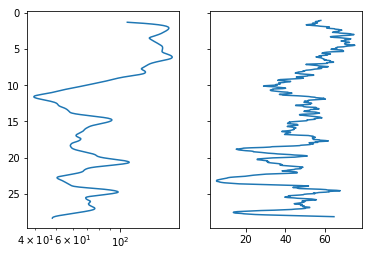

In [26]:
infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\gamma_induction\output_las\RN030885_induction_gamma.LAS"
plot_induction_gamma_logs(infile, 'INDUCTION_CALIBRATED','GAMMA_CALIBRATED')